This is a demonstration of the "raw" TensorFlow 2.0 (eager) API.  
We get to see manual parameter creation, manual graph building, and manual gradient updates.  
After seeing how TF works, we can start throwing on helpers, wrappers, and managers for convenience and performance (like running operations on GPU).

Reference: https://www.tensorflow.org/tutorials/quickstart/advanced

In [1]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


# Fetch the data

In [31]:
# Download MNIST dataset into numpy tensors.

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1) / 255
x_test = x_test.reshape(x_test.shape[0], -1) / 255
y_train = np.int_(y_train)
y_test = np.int_(y_test)

In [32]:
# How big is our dataset? What kind of data do we have? 

print(x_train.shape, ', ', x_train.dtype)
print(y_train.shape, ', ', y_train.dtype)
print()
print(x_test.shape, ', ', x_test.dtype)
print(y_test.shape, ', ', y_test.dtype)

(60000, 784) ,  float64
(60000,) ,  int64

(10000, 784) ,  float64
(10000,) ,  int64


In [7]:
# Look at an example
# Images are monochrome with integer pixel values between 0 and 255 (inclusive)

np.set_printoptions(linewidth=1000)
print(x_train[0].reshape(28, 28))

[[0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        

5


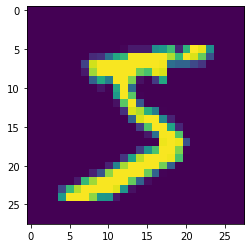


0


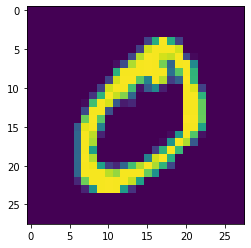


4


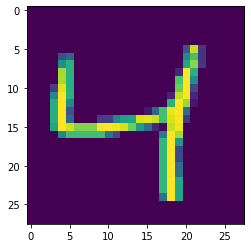


1


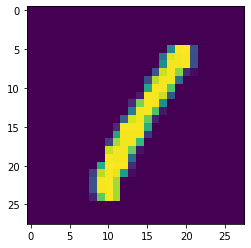


9


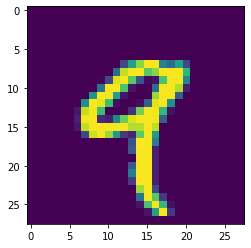


2


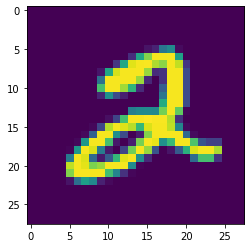

In [8]:
# Visualize some images and check their labels

import matplotlib.pyplot as plt
import numpy as np

for i in range(6):
  print(y_train[i])
  plt.imshow(x_train[i].reshape(28, 28))
  plt.show()
  print('')

# Define the model

In [9]:
INPUT_DIM = x_train.shape[-1]
HIDDEN_DIM = 256
OUTPUT_DIM = 10

# Define and initialize the model parameters by sampling each element i.i.d. from a normal distribution
SCALE = 1e-2
W1 = tf.Variable(SCALE * np.random.normal(size=(INPUT_DIM, HIDDEN_DIM)))
W2 = tf.Variable(SCALE * np.random.normal(size=(HIDDEN_DIM, OUTPUT_DIM)))
B1 = tf.Variable(SCALE * np.random.normal(size=(1, HIDDEN_DIM)))
B2 = tf.Variable(SCALE * np.random.normal(size=(1, OUTPUT_DIM)))

parameters = [W1, W2, B1, B2]

@tf.function
def model_fn(x):
  # x.shape=(batch_size, INPUT_DIM)
  h = tf.nn.relu(tf.matmul(x, W1) + B1)
  return tf.matmul(h, W2) + B2

In [12]:
# Test out our model

out = model_fn(x_train[:23])
print(out.shape)

(23, 10)


In [13]:
# View our parameters

print(W1)
print(B1)

<tf.Variable 'Variable:0' shape=(784, 256) dtype=float64, numpy=
array([[ 0.01411251, -0.00752985,  0.00459507, ...,  0.01846662,  0.01332022, -0.01119809],
       [ 0.01792152,  0.01476725, -0.00296863, ..., -0.00637372,  0.01743919,  0.0059461 ],
       [ 0.00301557, -0.00402558,  0.00949859, ..., -0.01183803, -0.0067778 , -0.00891522],
       ...,
       [-0.00349556,  0.00931434, -0.01918552, ..., -0.00116612,  0.00703204, -0.00713776],
       [ 0.0154672 , -0.00010778, -0.00744618, ...,  0.0043143 , -0.00833839,  0.00180832],
       [-0.00775696,  0.01438929, -0.00842793, ...,  0.00105868,  0.01120812, -0.0010258 ]])>
<tf.Variable 'Variable:0' shape=(1, 256) dtype=float64, numpy=
array([[ 1.01718414e-02,  3.63553630e-03,  8.71043322e-03, -7.49211135e-03, -9.68446503e-03,  3.36090497e-03, -1.60991954e-02, -4.87776515e-03,  5.40482030e-03,  8.10156606e-04,  2.16155530e-04, -6.75666908e-03,  3.51456802e-03,  1.35700499e-02,  2.48928326e-03,  1.98766288e-02,  1.15376900e-02, -1.040275

In [55]:
# Define the loss function

@tf.function
def select_indices(x, indices):
  # From row i, select element indices[i], i.e.
  # return [x[i, indices[i]] for i in range(x.shape[0])]

  # See https://stackoverflow.com/a/48491902/15601980
  row_indices = tf.range(indices.shape[0], dtype=tf.int64)
  full_indices = tf.stack([row_indices, indices], axis=1)
  return tf.gather_nd(x, full_indices)

# Maximum likelihood loss (negative log probability of the data)
@tf.function
def mle_loss(logits, labels):
  # equivalent to cross entropy loss where target probs are 1 on the correct labels
  # https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy
  logits_adjusted = tf.nn.log_softmax(logits, axis=1)  # rescale outputs in log space
  return -tf.reduce_mean(select_indices(logits_adjusted, labels))

***Cross entropy loss***

See https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy.

Let $\vec{q} = (q_1, \dots, q_n)$ be a vector of predicted probabilities,  
and let $\vec{p} = (p_1, \dots, p_n)$ be a vector of target probabilities.

The [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) of the two distributions is

$$
H(\vec{p}, \vec{q}) = -\sum_{i=1}^n p_i \log q_i
$$

Holding $\vec{p}$ fixed, $H(\vec{p}, \vec{q})$ is maximized when $\vec{q} = \vec{p}$.

In our case, the labels provide a one-hot target distribution.  
Let $t$ be the target label for some input image.
A one-hot distribution puts all probability on $t$, i.e.

$$\vec{\mathbb{1}}[t] = (0,\dots,0,1,0,\dots,0)$$

where $\mathbb{1}[t]_t = 1$.
Let $\vec{Y}$ be the raw model outputs and $\vec{q}$ be the model probabilities, i.e. 

$$
\vec{q} = \text{softmax}(\vec{Y}) = \frac{1}{\sum_{i=1}^n \exp(Y_i)}\Big(\exp(Y_1),\dots,\exp(Y_n)\Big)
$$

and let $\vec{p} = \vec{\mathbb{1}}[t]$.


Then the cross entropy loss (negated so that minimizing maximizes cross entropy) is


$$\begin{aligned}
L &= -H(\vec{p}, \vec{q}) \\
&= -H\left(\vec{\mathbb{1}}[t],\ \text{softmax}(\vec{Y})\right) \\
&= \sum_{i=1}^n \mathbb{1}[t]_i \log\left( \text{softmax}(\vec{Y}) \right)\\
&= \log\left( \text{softmax}(\vec{Y})_t \right) \\
&= Y_t - \log\left(\sum_{i=1}^n \exp(Y_i)\right)
\end{aligned}$$



In [48]:
@tf.function
def accuracy(logits, target):
  argmaxs = tf.math.argmax(logits, axis=1)
  corrects = tf.math.equal(argmaxs, target)
  return tf.math.count_nonzero(corrects) / logits.shape[0]

# Training loop

In [53]:
@tf.function
def train_step(images, labels, lr):
  with tf.GradientTape() as tape:
    predictions = model_fn(images)
    loss = mle_loss(labels, predictions)
    loss += regularizer_weight * sum(tf.norm(p, 1) for p in parameters)  # regularization
  gradients = tape.gradient(loss, parameters)

  for p, g in zip(parameters, gradients):
    p.assign_sub(lr * g)

  return loss

In [54]:
batch_size = 100
learning_rate = 1e-2
num_epochs = 1000
regularizer_weight = 1e-2

for epoch in range(batch_size):
  idx = np.random.permutation(x_train.shape[0])  # random ordering of the training set

  ## training step
  for i in range(0, x_train.shape[0], batch_size):
    x = x_train[idx[i:i+batch_size]]
    y = y_train[idx[i:i+batch_size]]

    loss_ = train_step(x, y, learning_rate).numpy()

    if i % (batch_size * 10) == 0:
      print('Step:', i//batch_size, '; Loss:', loss_)

  train_logits = model_fn(x_train)  # Training accurate
  test_logits = model_fn(x_test)  # Test accuracy
  print('Epoch: %d | Train Accuracy: %.2f | Test Accuracy: %.2f' % (epoch, accuracy(train_logits, y_train), accuracy(test_logits, y_test)))


InvalidArgumentError: ignored

In [57]:
tf.nn.log_softmax(model_fn(x_train[:12]), axis=1)

<tf.Tensor: shape=(12, 10), dtype=float64, numpy=
array([[-2.29320468, -2.29542503, -2.29466739, -2.28844269, -2.30084379, -2.28815989, -2.2884959 , -2.31155667, -2.32063713, -2.34595434],
       [-2.29487758, -2.28722329, -2.30549715, -2.27428899, -2.29613654, -2.29534531, -2.29924946, -2.31403684, -2.31777046, -2.34302142],
       [-2.29312368, -2.2829531 , -2.30576224, -2.29347094, -2.29177016, -2.30495721, -2.2979334 , -2.31881226, -2.30135181, -2.33678391],
       [-2.30054673, -2.28633173, -2.30503121, -2.28092874, -2.28718114, -2.30223683, -2.29905165, -2.30999332, -2.31624961, -2.33959647],
       [-2.29086755, -2.29581227, -2.3054109 , -2.28132601, -2.30359305, -2.2942334 , -2.3077953 , -2.30446546, -2.30915204, -2.3340816 ],
       [-2.28498991, -2.28973046, -2.30662879, -2.28436285, -2.29927116, -2.28609334, -2.30520388, -2.3185883 , -2.30576827, -2.34687232],
       [-2.29889728, -2.28938111, -2.30721935, -2.28854125, -2.29956319, -2.2939172 , -2.29223423, -2.30929129, -2.3